This tutorial demonstrates how researchers in **machine learning** and **simulation-based inference (SBI)** can seamlessly integrate their methods into the `ncpi` pipeline to infer **cortical circuit parameters** from simulations of **population-level electrophysiological data**. We will explore how to train learning models using both `scikit-learn` and `sbi`, while also leveraging **repeated K-Fold cross-validation** during training to ensure robust performance.

First, we’ll generate simulated data using the same simple simulator introduced in the <a href="../tutorials/getting_started.html" target="_blank" rel="noopener">*Getting started*</a> tutorial, providing a consistent foundation for further analysis.

In [6]:
import numpy as np
import ncpi
import pandas as pd

def simulator(θ, n_neurons=50, sim_time=2000, sampling_rate=100):
    """
    Simulates spike trains modulated by a shared sinusoidal signal and independent noise.

    Parameters
    ----------
    θ : float
        Controls the exponential decay of the synaptic kernel and the influence of the shared signal.
    n_neurons: int, optional
        Number of neurons to simulate. Default is 50.
    sim_time: int, optional
        Length of the simulation in time points. Default is 2000.
    sampling_rate: int, optional
        Sampling rate in Hz (or time points per second). Default is 100.

    Returns
    -------
    spikes : ndarray of shape (n_neurons, sim_time)
        Binary array representing spikes (1s) and no spikes (0s) for each neuron over time.
    exp_kernel : ndarray
        The exponential kernel used for convolution.
    """
    spikes = np.zeros((n_neurons, sim_time))

    # Synaptic kernel
    tau = sampling_rate * (θ + 0.01)
    t_kernel = np.arange(int(sampling_rate * 4))
    exp_kernel = np.exp(-t_kernel / tau)

    # Sinusoidal shared signal
    freq = 2.0  # Hz
    time = np.arange(sim_time) / sampling_rate
    shared_input = 0.5 * (1 + np.sin(2 * np.pi * freq * time))  # Values in [0, 1]

    for neuron in range(n_neurons):
        # Independent signal for each neuron
        private_input = np.random.rand(sim_time)
        private_modulated = np.convolve(private_input, exp_kernel, mode='same')

        # Combine shared and private inputs
        k = 0.5 * θ # Mixing coefficient based on θ
        modulated = private_modulated + k * np.convolve(shared_input, exp_kernel, mode='same')

        # Normalize combined modulation
        modulated -= modulated.min()
        modulated /= modulated.max()

        # Generate spikes
        spike_probs = modulated - 0.9
        spikes[neuron] = np.random.rand(sim_time) < spike_probs

    return spikes, exp_kernel

# Set simulation parameters
n_neurons = 50           # Number of neurons in each simulated recording
sim_time = 2000          # Total number of time points per sample
sampling_rate = 100      # Sampling rate in Hz
n_samples = 1000        # Total number of samples (combined training + test set)

# Define the bin size and number of bins for firing rate computation
bin_size = 100  # ms
bin_size = int(bin_size * sampling_rate / 1000)  # convert to time steps
n_bins = int(sim_time / bin_size) # Number of bins

# Preallocate arrays for storing simulation output
sim_data = {
    'X': np.zeros((n_samples, n_bins)),
    'θ': np.zeros((n_samples, 1))
}

# Create the simulation dataset
for sample in range(n_samples):
    # Generate a random parameter θ
    θ = np.random.uniform(0, 0.5)

    # Simulate the spike train
    spikes, exp_kernel = simulator(θ, sampling_rate=sampling_rate,
                                      n_neurons=n_neurons,
                                      sim_time=sim_time)

    # Compute firing rates
    fr = [
        [np.sum(spikes[ii, jj * bin_size:(jj + 1) * bin_size])
         for jj in range(n_bins)]
         for ii in range(spikes.shape[0])
    ]

    # Create a FieldPotential object
    fp = ncpi.FieldPotential(kernel = False)

    # Get the field potential proxy
    proxy = fp.compute_proxy(method = 'FR', sim_data = {'FR': fr}, sim_step = None)

    # Save simulation data
    sim_data['X'][sample, :] = proxy
    sim_data['θ'][sample, 0] = θ

# If sim_data['θ'] is a 2D array with one column, reshape it to a 1D array
if sim_data['θ'].shape[1] == 1:
    sim_data['θ'] = np.reshape(sim_data['θ'], (-1,))

# Compute features
df = pd.DataFrame({'Data': sim_data['X'].tolist()})
features = ncpi.Features(method='catch22')
df = features.compute_features(df)

Computing features: 100%|██████████| 334/334 [00:01<00:00, 206.69it/s]


We split the data into 90% for training and 10% for testing, as is typically done in the other tutorials.

In [7]:
# Split simulation data into 90% training and 10% test data
indices = np.arange(n_samples)
np.random.shuffle(indices)
split = int(0.9 * len(indices))
train_indices = indices[:split]
test_indices = indices[split:]

X_train = np.array(df.iloc[train_indices].drop(columns=['Data'])['Features'].tolist())
X_test = np.array(df.iloc[test_indices].drop(columns=['Data'])['Features'].tolist())
θ_train = np.array(sim_data['θ'][train_indices])
θ_test = np.array(sim_data['θ'][test_indices])

We now perform a **repeated cross-validation grid search** (5 splits, 1 repeat) across a range of hyperparameters for three different algorithms: `MLPRegressor` and `RandomForestRegressor` from `scikit-learn`, and `NPE` from `sbi`. The hyperparameters for each model are specified using the `param_grid` argument of the `train` function.

In [8]:
import pickle

# Define hyperparameters for each model
hyperparams = {'MLPRegressor': [{'hidden_layer_sizes': (50,50), 'max_iter': 100},
                                {'hidden_layer_sizes': (100,100), 'max_iter': 100}],
               'RandomForestRegressor': [{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2},
                                         {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5}],
               'NPE': [{'prior': None, 'density_estimator': {'model':"maf", 'hidden_features':25,'num_transforms':2}},
                       {'prior': None, 'density_estimator': {'model':"maf", 'hidden_features':50,'num_transforms':5}}]}

train_models = {}

for model in hyperparams.keys():
    print(f"Training {model} with hyperparameters: {hyperparams[model]}")

    # Initialize the inference model, add simulation data, and train the model
    inference = ncpi.Inference(model=model)
    inference.add_simulation_data(X_train, θ_train)
    inference.train(param_grid=hyperparams[model], n_splits=5, n_repeats=1)

    # Evaluate the model using the test data
    predictions = inference.predict(X_test)

    # Save the trained model and predictions
    if model == 'NPE':
        with open('data/density_estimator.pkl', 'rb') as f:
            density_estimator = pickle.load(f)
    else:
        density_estimator = None
    with open('data/model.pkl', 'rb') as f:
        inference = pickle.load(f)
    with open('data/scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    train_models[model] = [inference, density_estimator, scaler, predictions]

Training MLPRegressor with hyperparameters: [{'hidden_layer_sizes': (50, 50), 'max_iter': 100}, {'hidden_layer_sizes': (100, 100), 'max_iter': 100}]


--> Hyperparameters: {'hidden_layer_sizes': (50, 50), 'max_iter': 100}
Repeat 1, Fold 5

--> Hyperparameters: {'hidden_layer_sizes': (100, 100), 'max_iter': 100}
Repeat 1, Fold 5

--> Best hyperparameters: {'hidden_layer_sizes': (100, 100), 'max_iter': 100, 'random_state': 0}



Computing predictions: 100%|██████████| 34/34 [00:01<00:00, 21.80it/s]


Training RandomForestRegressor with hyperparameters: [{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2}, {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5}]


--> Hyperparameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2}
Repeat 1, Fold 5

--> Hyperparameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5}
Repeat 1, Fold 5

--> Best hyperparameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5, 'random_state': 0}



Computing predictions: 100%|██████████| 34/34 [00:01<00:00, 17.86it/s]

Training NPE with hyperparameters: [{'prior': None, 'density_estimator': {'model': 'maf', 'hidden_features': 25, 'num_transforms': 2}}, {'prior': None, 'density_estimator': {'model': 'maf', 'hidden_features': 50, 'num_transforms': 5}}]


--> Hyperparameters: {'prior': None, 'density_estimator': {'model': 'maf', 'hidden_features': 25, 'num_transforms': 2}}


Repeat 1, Fold 1


/home/pablomc/anaconda3/envs/ncpi-env/lib/python3.10/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(




 Neural network successfully converged after 229 epochs.

Repeat 1, Fold 2

 Neural network successfully converged after 200 epochs.

Repeat 1, Fold 3

 Neural network successfully converged after 175 epochs.

Repeat 1, Fold 4

 Neural network successfully converged after 159 epochs.

Repeat 1, Fold 5

 Neural network successfully converged after 169 epochs.

--> Hyperparameters: {'prior': None, 'density_estimator': {'model': 'maf', 'hidden_features': 50, 'num_transforms': 5}}


Repeat 1, Fold 1

 Neural network successfully converged after 85 epochs.

Repeat 1, Fold 2

 Neural network successfully converged after 91 epochs.

Repeat 1, Fold 3

 Neural network successfully converged after 96 epochs.

Repeat 1, Fold 4

 Neural network successfully converged after 98 epochs.

Repeat 1, Fold 5

 Neural network successfully converged after 113 epochs.

--> Best hyperparameters: {'prior': None, 'density_estimator': {'model': 'maf', 'hidden_features': 25, 'num_transforms': 2}}



/home/pablomc/OneDrive/2024/cortical_circuit_parameter_inference/ncpi/ncpi/Inference.py:421: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickle.dump(model, file)


Plot the predicted values against the true values for each model, along with the mean squared error (MSE) for each model.

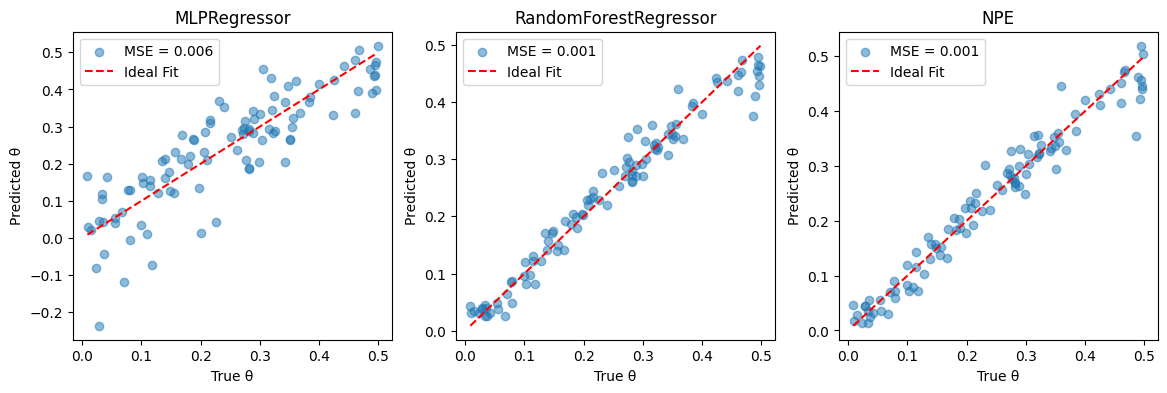

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(1,3, figsize=(14, 4))

for (ax, model) in zip(axes, train_models.keys()):
    predictions = train_models[model][-1]

    # Calculate MSE
    mse = mean_squared_error(θ_test, predictions)

    # Plot real vs predicted values
    ax.scatter(θ_test, predictions, alpha=0.5, label=f'MSE = {mse:.3f}')
    ax.plot([θ_test.min(), θ_test.max()], [θ_test.min(), θ_test.max()], 'r--', label='Ideal Fit')
    ax.set_title(model)
    ax.set_xlabel('True θ')
    ax.set_ylabel('Predicted θ')
    ax.legend()

plt.show()

Finally, we can also plot the posterior samples obtained from the `NPE` model. This will allow us to visualize the distribution of the inferred parameters based on a single observation from the test set.

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 1177811.35it/s]


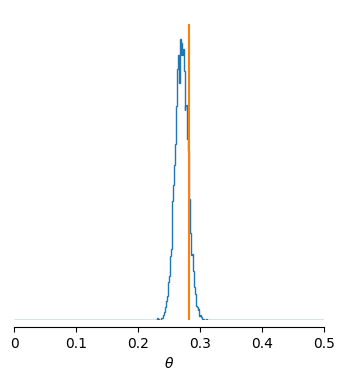

In [12]:
from sbi.analysis import pairplot
import torch

# Load the trained NPE model and density estimator
inference = train_models['NPE'][0]
density_estimator = train_models['NPE'][1]

# Pick our observation from the test set
theta_true = θ_test[0]
x_obs = X_test[0]

# Scale the observation and convert to tensor
x_obs = scaler.transform(x_obs.reshape(1, -1))
x_obs = torch.tensor(x_obs, dtype=torch.float32)

# Build the posteriors and sample from them: there is one posterior for each fold of the cross-validation
samples = []
for fold in range(len(inference)):
    posterior = inference[fold].build_posterior(density_estimator[fold])
    samples.append(posterior.sample((10000,), x=x_obs))

# Average the sorted posterior samples across folds
samples = np.array(samples)
samples_mean = np.mean(np.sort(samples,axis = 0), axis=0)

# Pairplot the samples
_ = pairplot(samples_mean,
             points=theta_true,
             limits=[[0, 0.5]],
             figsize=(4,4),
             labels=[r"$\theta$"])